# Markov Chain Monte Carlo and Bayesian Inference with Continuous Varibles

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_context('poster')

%matplotlib inline

import pymc3 as pm

import scipy

# Data Exploration

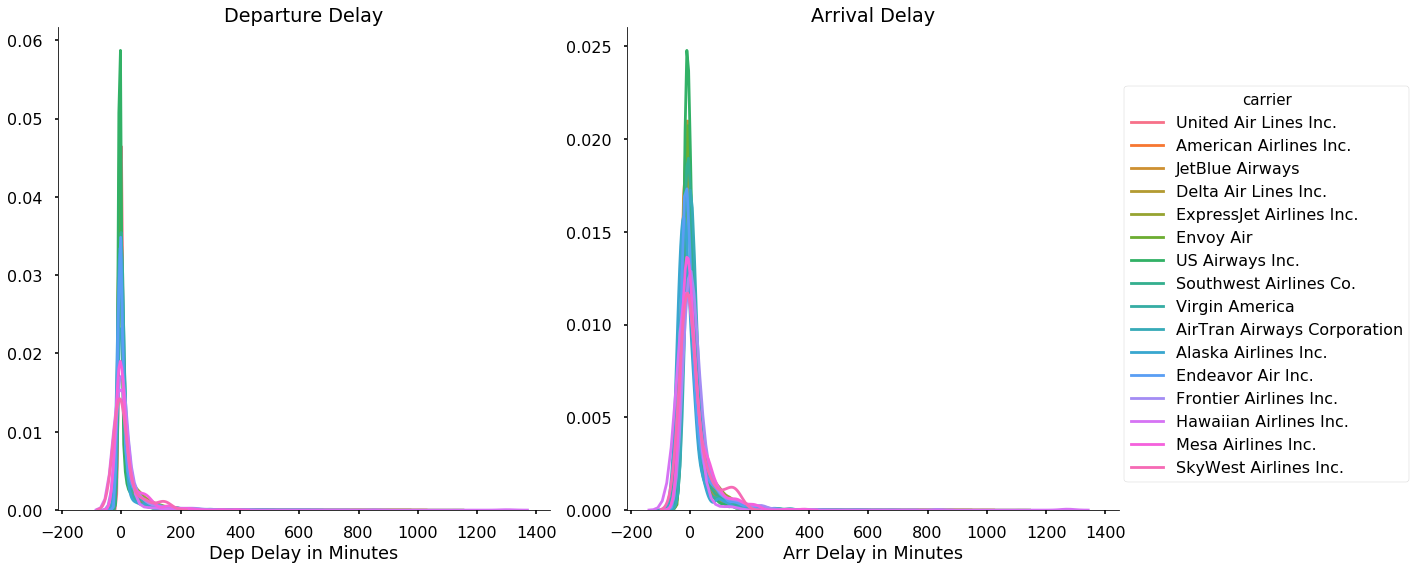

In [3]:
flights = pd.read_csv('data/flights.csv', index_col=0)
flights.dropna(subset=['dep_delay', 'arr_delay'], inplace=True)

carriers = pd.read_csv('data/airlines.csv')
flights = flights.merge(carriers, how = 'left', on = 'carrier' )
flights['carrier'] = flights['name']
flights.drop(columns='name', inplace=True)


flights_subset = flights[['carrier', 'dep_delay', 'arr_delay']]
flights_melted = flights_subset.melt(id_vars='carrier', value_name='value', var_name='type')

figsize(16, 8)
grid = sns.FacetGrid(flights_melted, col = 'type', hue = 'carrier', size=8, sharey=False)
grid.map(sns.kdeplot, 'value')
grid.add_legend();
ax1 = grid.axes[0][0]
ax1.set_xlabel('Dep Delay in Minutes')
ax1.set_title('Departure Delay')

ax2 = grid.axes[0][1]
ax2.set_xlabel('Arr Delay in Minutes')
ax2.set_title('Arrival Delay');
plt.ylabel('Density Estimate');

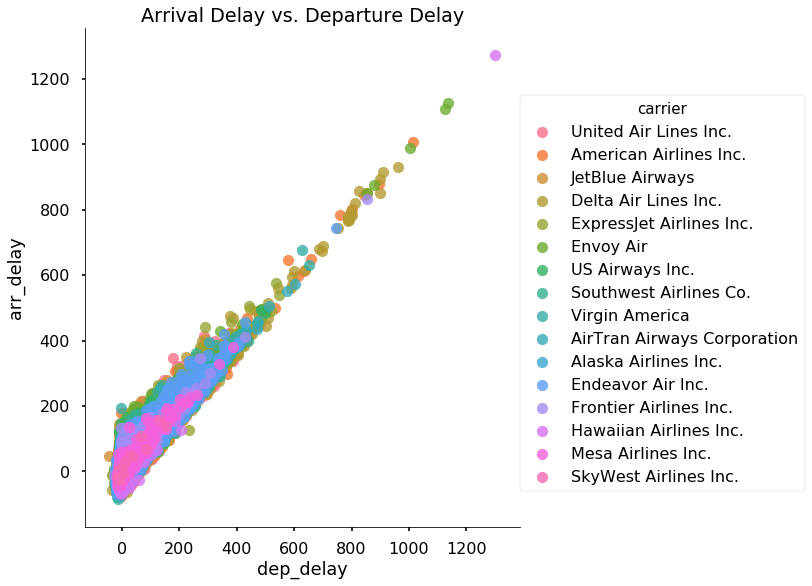

In [4]:
sns.lmplot('dep_delay', 'arr_delay', flights, 
           fit_reg = False, hue = 'carrier', size = 8);
plt.title('Arrival Delay vs. Departure Delay');

In [9]:
flights = flights.sample(frac=1, random_state=50)[:10000]

In [10]:
carriers = flights['carrier'].unique()
carrier_lookup = dict(zip(carriers, range(len(carriers))))
carrier_codes = flights['carrier_code'] = flights['carrier'].replace(carrier_lookup).values

# Hierarchical Model for Flight Delay

In [12]:
dep = np.array(flights['dep_delay'].values)
arr = np.array(flights['arr_delay'].values)

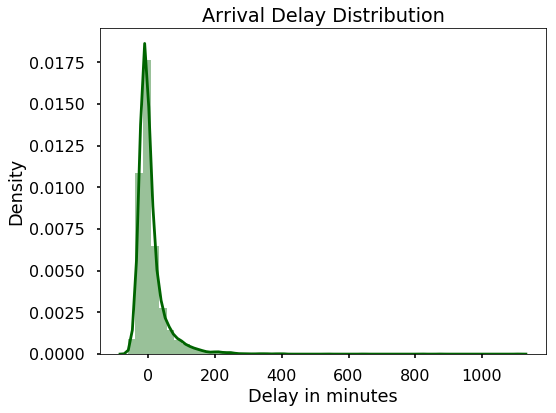

In [13]:
plt.figure(figsize=(8, 6))
sns.distplot(arr, color = 'darkgreen')
plt.title('Arrival Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

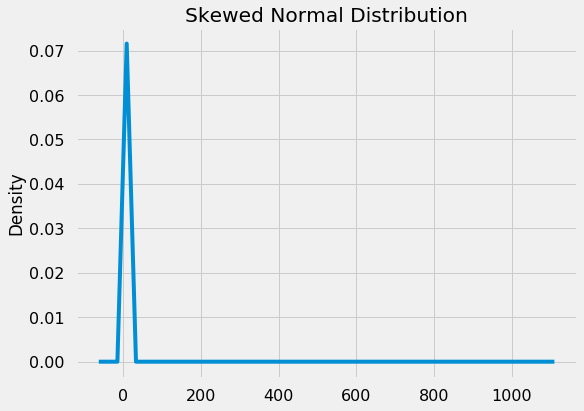

In [58]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(arr), max(arr))
skewed = scipy.stats.skewnorm.pdf(x, loc = np.mean(arr), a = scipy.stats.skew(arr))
plt.plot(x, skewed);
plt.title('Skewed Normal Distribution')
plt.ylabel('Density');

In [21]:
print('Correlation between departure delay and arrival delay: {:.4f}.'.
      format(np.corrcoef(arr, dep)[0][1]))
print('Skew of Arrival Delay: {:.4f}.'.format(scipy.stats.skew(arr)))
print('Average Delay Time: {:.4f} minutes.'.format(np.mean(arr)))

Correlation between departure delay and arrival delay: 0.9221.
Skewed of Arrival Delay: 5.2174.
Average Delay Time: 7.4978.


In [46]:
# Treat all of observations as coming from same distribution
with pm.Model() as pooled_model:
    
    # Alpha is skew of distribution
    alpha = pm.Normal('alpha', mu = 0, sd = 10)
    
    # Beta is vector of model parameters: [intercept, slope]
    beta = pm.Normal('beta', mu = 0, sd = 10, shape=2)
    
    # Sigma is standard deviation of observations
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Linear equation for the arrival delay based on departure delay
    theta = beta[0] + beta[1] * dep
    
    # The arrival delays are skewed normal
    y = pm.SkewNormal('y', mu=theta, sd=sigma, alpha=alpha, observed=arr)
    
    # Trace from pooled model
    pooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001BF571C0F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001BF571C0F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 24, 20, 10, 30, 656215, tzinfo=tzutc()), 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'session': '32a20986d6e308b5d80cc05772ff28bc', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'32a20986d6e308b5d80cc05772ff28bc']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 24, 20, 10, 30, 656215, tzinfo=tzutc()), 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'session': '32a20986d6e308b5d80cc05772ff28bc', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'32a20986d6e308b5d80cc05772ff28bc'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 24, 20, 10, 30, 656215, tzinfo=tzutc()), 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'session': '32a20986d6e308b5d80cc05772ff28bc', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '364aa288df57ccca3c6d8e5af8b5ae56', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-46-6911f7fab465>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1bf78e923c8, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001BF74458B70, file "<ipython-input-46-6911f7fab465>", line 2>
        result = <ExecutionResult object at 1bf78e923c8, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001BF74458B70, file "<ipython-input-46-6911f7fab465>", line 2>, result=<ExecutionResult object at 1bf78e923c8, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001BF74458B70, file "<ipython-input-46-6911f7fab465>", line 2>
        self.user_global_ns = {'In': ['', "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "flights = pd.read_csv('data/flights.csv', index_...elay in Minutes')\nax2.set_title('Arrival Delay');", "sns.lmplot('dep_delay', 'arr_delay', flights, \n ...;\nplt.title('Arrival Delay vs. Departure Delay');", "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", 'flights.head()', 'carrier_codes', 'flights = flights.sample(freq=1, random_state=50)[:10000]', 'flights = flights.sample(frac=1, random_state=50)[:10000]', "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", 'flights.shape', "dep = np.array(flights['dep_delay'].values)\narr = np.array(flights['arr_delay'].values)", "plt.figure(figsize=(8, 6))\nsns.distplot(arr, col...label('Delay in minutes'); plt.ylabel('Density');", 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...a = scipy.stats.skew(arr))\nsns.distplot(skewed));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d... a = scipy.stats.skew(arr))\nsns.distplot(skewed);', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', "plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...ewed Normal Distribution')\nplt.xlabel('Density');", ...], 'Out': {6:    year  month  day  dep_time  sched_dep_time  d...   6       0  2013-01-01 06:00:00             3  , 7: array([0, 0, 1, ..., 2, 2, 2], dtype=int64), 11: (10000, 20), 38: <matplotlib.axes._subplots.AxesSubplot object>, 40: 2.2483405830307372, 41: -24.116979589303604, 42: 26.05884716352473}, '_': 26.05884716352473, '_11': (10000, 20), '_38': <matplotlib.axes._subplots.AxesSubplot object>, '_40': 2.2483405830307372, '_41': -24.116979589303604, '_42': 26.05884716352473, '_6':    year  month  day  dep_time  sched_dep_time  d...   6       0  2013-01-01 06:00:00             3  , '_7': array([0, 0, 1, ..., 2, 2, 2], dtype=int64), ...}
        self.user_ns = {'In': ['', "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "flights = pd.read_csv('data/flights.csv', index_...elay in Minutes')\nax2.set_title('Arrival Delay');", "sns.lmplot('dep_delay', 'arr_delay', flights, \n ...;\nplt.title('Arrival Delay vs. Departure Delay');", "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", 'flights.head()', 'carrier_codes', 'flights = flights.sample(freq=1, random_state=50)[:10000]', 'flights = flights.sample(frac=1, random_state=50)[:10000]', "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", 'flights.shape', "dep = np.array(flights['dep_delay'].values)\narr = np.array(flights['arr_delay'].values)", "plt.figure(figsize=(8, 6))\nsns.distplot(arr, col...label('Delay in minutes'); plt.ylabel('Density');", 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...a = scipy.stats.skew(arr))\nsns.distplot(skewed));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d... a = scipy.stats.skew(arr))\nsns.distplot(skewed);', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', 'plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...stats.skew(arr))\nsns.distplot(skewed * max(dep));', "plt.figure(figsize=(8, 6))\nx = np.linspace(min(d...ewed Normal Distribution')\nplt.xlabel('Density');", ...], 'Out': {6:    year  month  day  dep_time  sched_dep_time  d...   6       0  2013-01-01 06:00:00             3  , 7: array([0, 0, 1, ..., 2, 2, 2], dtype=int64), 11: (10000, 20), 38: <matplotlib.axes._subplots.AxesSubplot object>, 40: 2.2483405830307372, 41: -24.116979589303604, 42: 26.05884716352473}, '_': 26.05884716352473, '_11': (10000, 20), '_38': <matplotlib.axes._subplots.AxesSubplot object>, '_40': 2.2483405830307372, '_41': -24.116979589303604, '_42': 26.05884716352473, '_6':    year  month  day  dep_time  sched_dep_time  d...   6       0  2013-01-01 06:00:00             3  , '_7': array([0, 0, 1, ..., 2, 2, 2], dtype=int64), ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\Will Koehrsen\Documents\eecs-491\assign\A2\<ipython-input-46-6911f7fab465> in <module>()
     15     
     16     # The arrival delays are skewed normal
     17     y = pm.SkewNormal('y', mu=theta, sd=sigma, alpha=alpha, observed=arr)
     18     
     19     # Trace from pooled model
---> 20     pooled_trace = pm.sample(1000)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'alpha': array(-0.04442253), 'beta': array([ 0.2534379 , -0.96621122]), 'sigma_log__': array(1.76236428)}, {'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}], trace=None, chain_idx=0, chains=2, njobs=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[952019220, 391710819], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': [952019220, 391710819], 'start': [{'alpha': array(-0.04442253), 'beta': array([ 0.2534379 , -0.96621122]), 'sigma_log__': array(1.76236428)}, {'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _mp_sample(**kwargs={'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Feb 24 15:11:03 2018
PID: 16356        Python 3.6.4: C:\Users\Will Koehrsen\Anaconda3\python.exe
...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (1, False, 391710819, {'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}), {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (1, False, 391710819, {'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)})
        kwargs = {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _sample(chain=1, progressbar=False, random_seed=391710819, start={'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}, draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling = <generator object _iter_sample>
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _iter_sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}, trace=None, chain=1, tune=500, model=<pymc3.model.Model object>, random_seed=391710819)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\step_methods\arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'alpha': array(-0.95883129), 'beta': array([0.00493268, 0.34805493]), 'sigma_log__': array(0.68138291)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([ 0.68138291,  0.00493268,  0.34805493, -0.95883129])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 0.68138291,  0.00493268,  0.34805493, -0.95883129]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = inf
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: inf. The model might be misspecified.
___________________________________________________________________________

In [47]:
# Intercept and slope are mean of traces
pooled_intercept, pooled_slope = pooled_trace['beta'].mean(axis=0)
pooled_sigma = pooled_trace['sigma'].mean(axis=0)
pooled_alpha = pooled_trace['alpha'].mean(axis=0)

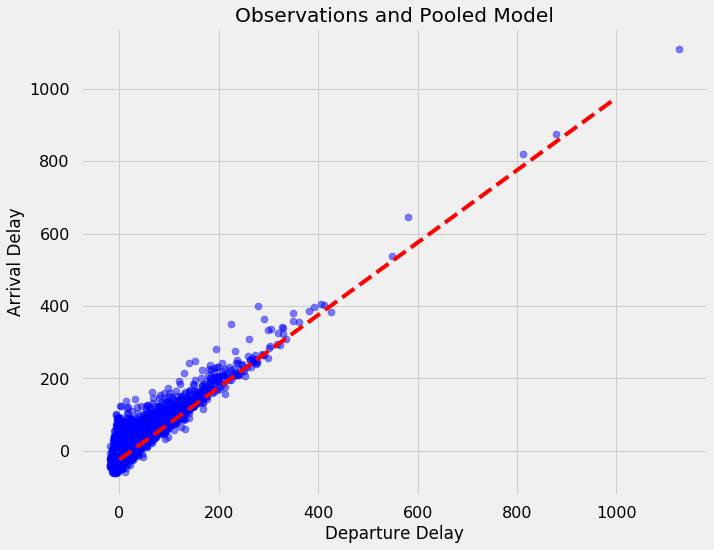

In [48]:
figsize(10, 8)
plt.style.use('fivethirtyeight')
plt.scatter(flights['dep_delay'], (flights['arr_delay']), s = 50, 
           alpha = 0.5, facecolor = 'b', edgecolors = 'b')
xvals = np.linspace(0, 1000)
plt.plot(xvals, pooled_slope * xvals + pooled_intercept, 
         'r--', label = 'Pooled Model Estimate');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');
plt.title('Observations and Pooled Model');

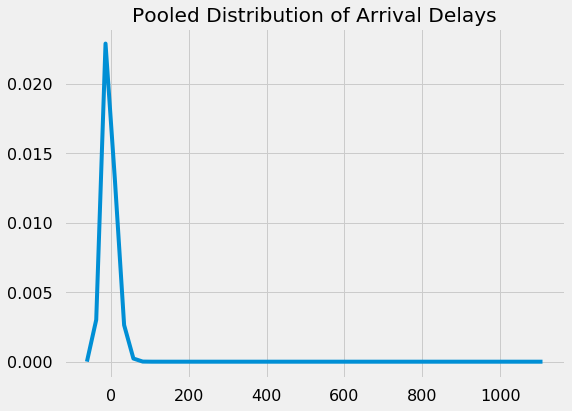

In [55]:
figsize(8, 6)
x = np.linspace(min(arr), max(arr))
pooled_dist = scipy.stats.skewnorm.pdf(x, loc = pooled_intercept, 
                                      scale = pooled_sigma, a = pooled_alpha)
plt.plot(x, pooled_dist)
plt.title('Pooled Distribution of Arrival Delays');

# Completely Unpooled Model

In [61]:
with pm.Model() as unpooled_model:
    # Alpha is skew of distribution
    alpha = pm.Normal('alpha', 0, 1e5)
    
    
    beta0 = pm.Normal('beta0', 0, sd = 1e5, shape = len(carriers))
    beta1 = pm.Normal('beta1', 0, sd = 1e5)
    
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = beta0[carrier_codes] + beta1 * dep
    
    y = pm.SkewNormal('y', theta, sd = sigma, alpha = alpha,
                     observed = arr)
    unpooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta1, beta0, alpha]
The acceptance probability does not match the target. It is 0.910695654823541, but should be close to 0.8. Try to increase the number of tuning steps.


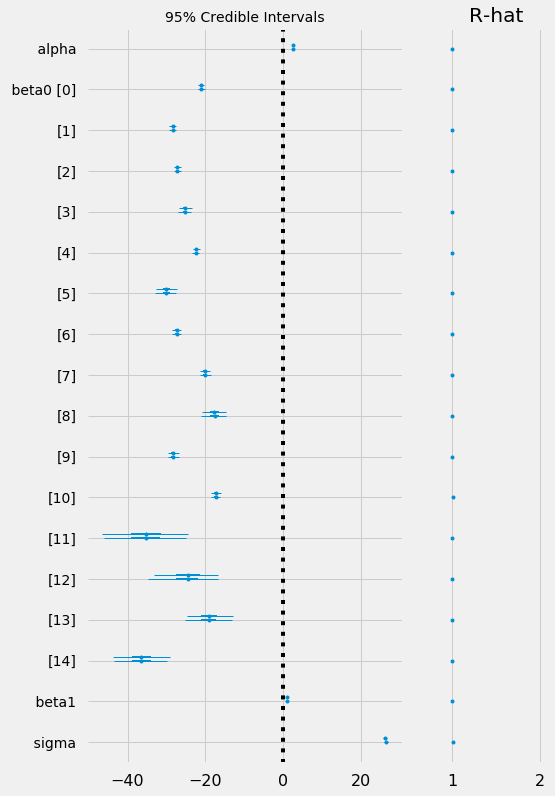

In [63]:
from pymc3 import forestplot

figsize(8, 12)
forestplot(unpooled_trace)

In [65]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = carriers)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = carriers)

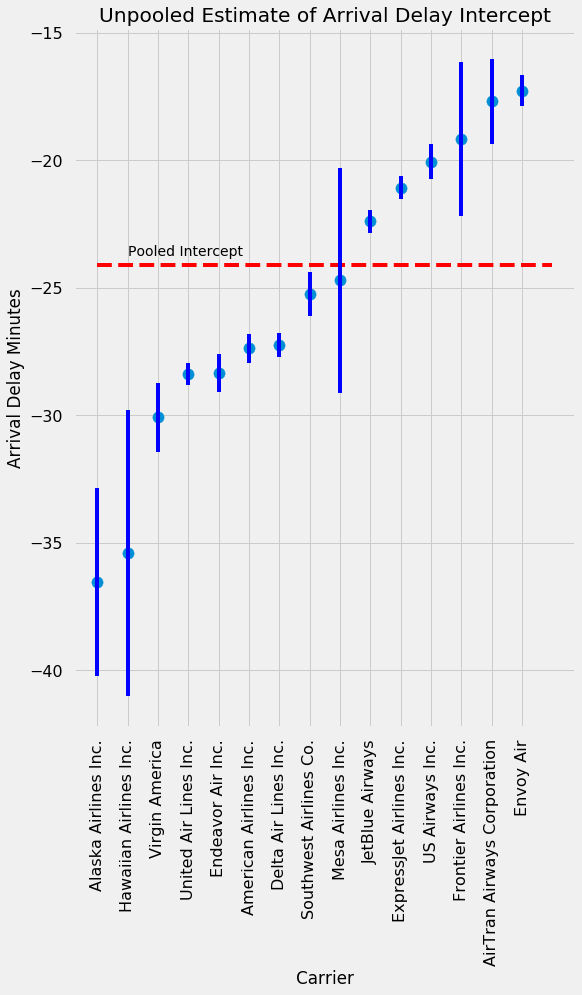

In [78]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i, i], [m - se, m + se], 'b-')
    
plt.xticks(range(len(unpooled_estimates)), order, rotation = 90);
plt.hlines( y = pooled_intercept, color = 'r', linestyles='--', xmin = 0, xmax = len(unpooled_estimates))
plt.text(x = 1, y = pooled_intercept + .4, s = 'Pooled Intercept')
plt.xlabel('Carrier'); plt.ylabel('Arrival Delay Minutes');
plt.title('Unpooled Estimate of Arrival Delay Intercept');

-36.52815277057549
-35.38825835258417
-30.086235337372095
-28.383182931081215
-28.330158266095744
-27.37318176283281
-27.251818783373608
-25.25394401833287


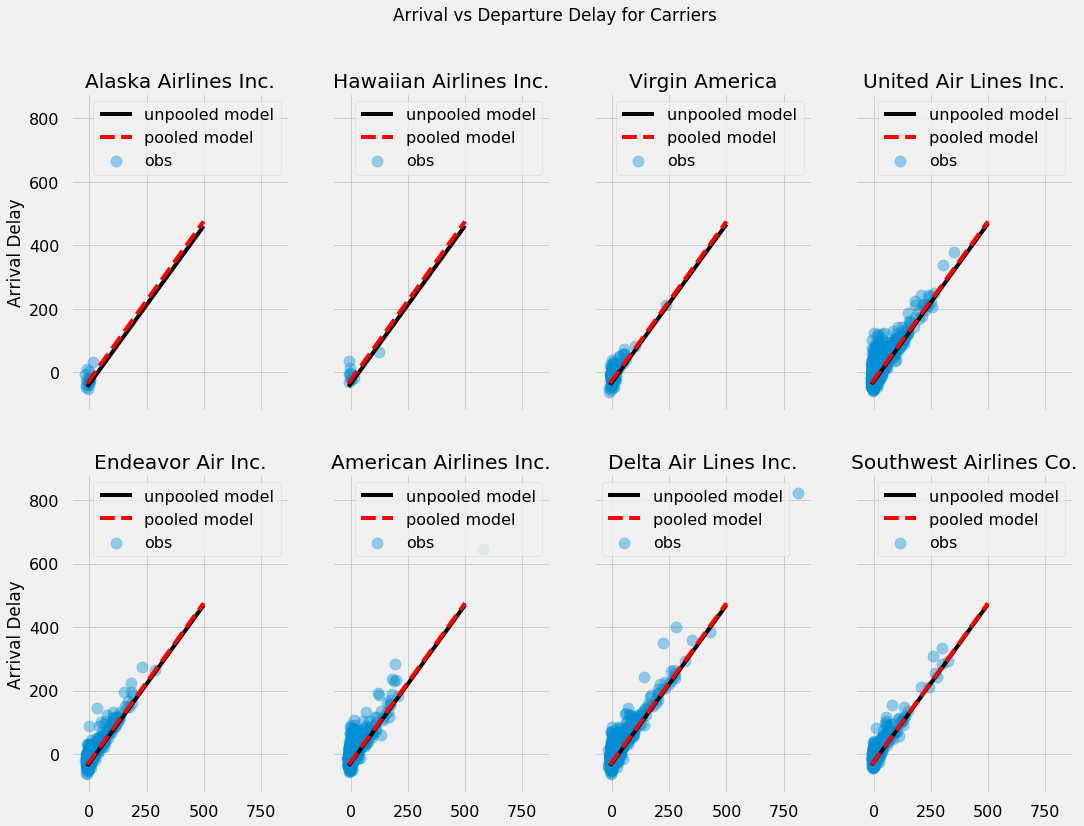

In [92]:
sample_airlines = tuple(order[:8])

fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()

for i,c in enumerate(sample_airlines):
    y = flights['arr_delay'][flights['carrier']==c]
    x = flights['dep_delay'][flights['carrier']==c]
    
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, 
                    alpha=0.4, label = 'obs')
    
    # No pooling model
    b = unpooled_estimates[c]
    # Plot both models and data
    xvals = np.linspace(-10, 500)
    axes[i].plot(xvals, m*xvals+b, label = 'unpooled model', color = 'k')
    axes[i].plot(xvals, pooled_slope*xvals+pooled_intercept, 'r--',
                label = 'pooled model')
    axes[i].set_title(c)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('Arrival Delay')
    
plt.suptitle('Arrival vs Departure Delay for Carriers');

In [86]:
ax = axes[1]

In [88]:
ax.legend()